<a href="https://colab.research.google.com/github/Isac-AS/FSI_Practica_Redes_Neuronales_Flores/blob/main/FSI_Practica_Redes_Neuronales_Flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación
Se monta el sistema de archivos de google drive.


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se comprueba que se está usando una GPU

In [24]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

El dataset empleado es el siguiente: https://www.kaggle.com/alxmamaev/flowers-recognition.
Se muestra una imagen de ejemplo

flowers_recognition  flowers_recognition.zip  Sign-Language  Sign-Language.zip


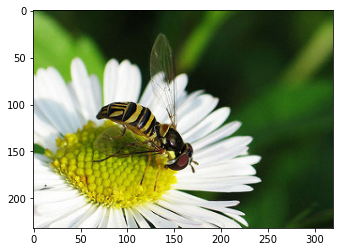

In [25]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers/daisy/5547758_eea9edfd54_n.jpg', 'r')
imshow(np.asarray(pil_im))



# Carga del dataset

In [26]:
image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


# Modelo

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

# Visualización del modelo

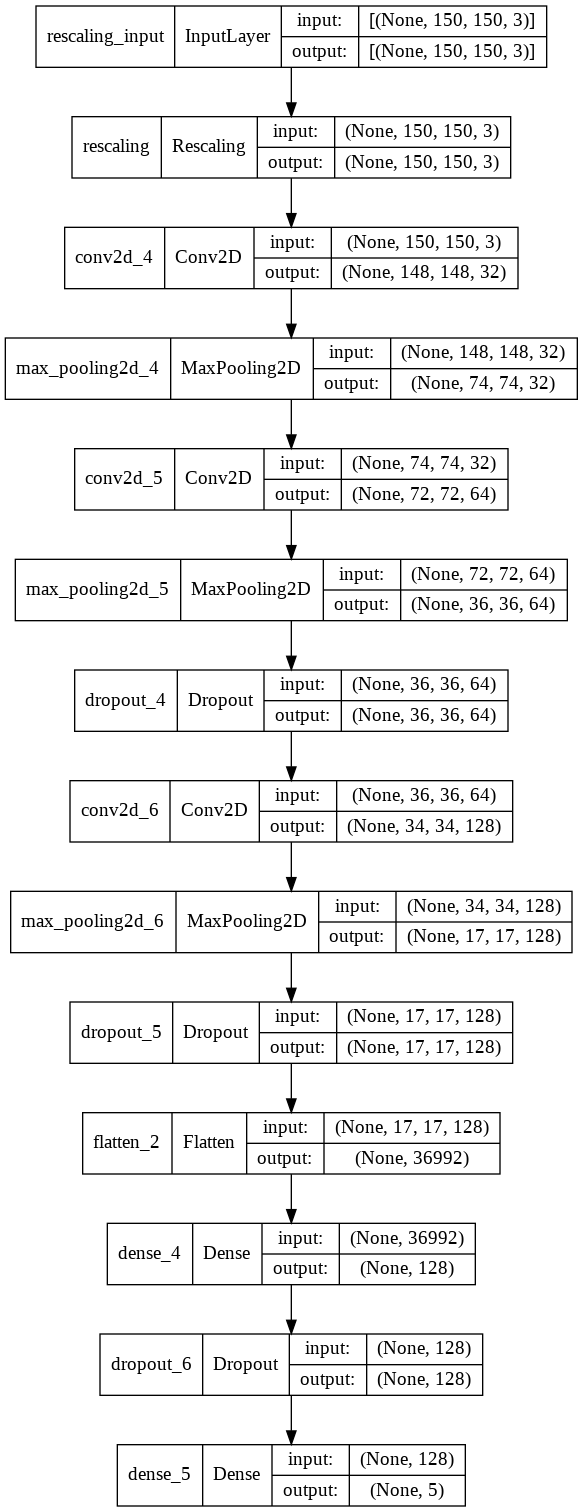

In [29]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

# Entrenamiento

In [30]:
epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10,
                   restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
108/108 [==============================] - 17s 134ms/step - loss: 1.3792 - accuracy: 0.4192 - val_loss: 1.1620 - val_accuracy: 0.5377
Epoch 2/200
108/108 [==============================] - 15s 129ms/step - loss: 1.1512 - accuracy: 0.5177 - val_loss: 1.1061 - val_accuracy: 0.5643
Epoch 3/200
108/108 [==============================] - 15s 129ms/step - loss: 1.0425 - accuracy: 0.5738 - val_loss: 1.0099 - val_accuracy: 0.5689
Epoch 4/200
108/108 [==============================] - 15s 135ms/step - loss: 0.9104 - accuracy: 0.6401 - val_loss: 0.9023 - val_accuracy: 0.6547
Epoch 5/200
108/108 [==============================] - 15s 129ms/step - loss: 0.8162 - accuracy: 0.6928 - val_loss: 0.8681 - val_accuracy: 0.6790
Epoch 6/200
108/108 [==============================] - 15s 130ms/step - loss: 0.7393 - accuracy: 0.7169 - val_loss: 0.9141 - val_accuracy: 0.6651
Epoch 7/200
108/108 [==============================] - 15s 130ms/step - loss: 0.6318 - accuracy: 0.7496 - val_loss: 0.8773 -

# Gráfica de evolución de pérdida y exactitud durante el entrenamiento

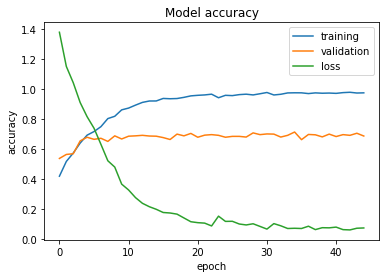

In [31]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

# Evaluación de los resultados

              precision    recall  f1-score   support

           0     0.6788    0.6458    0.6619       144
           1     0.7863    0.8000    0.7931       230
           2     0.5497    0.6640    0.6014       125
           3     0.8200    0.7987    0.8092       154
           4     0.6963    0.6333    0.6633       210

    accuracy                         0.7138       863
   macro avg     0.7062    0.7084    0.7058       863
weighted avg     0.7182    0.7138    0.7148       863



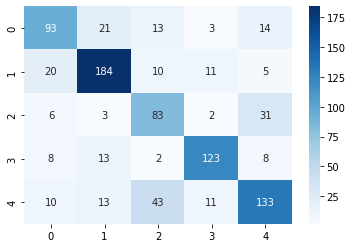

In [32]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [33]:
img = keras.preprocessing.image.load_img(
    '/content/drive/My Drive/Colab Notebooks/datasets/flowers_recognition/flowers/sunflower/6953297_8576bf4ea3.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

3
